In [1]:
import os, random,cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path
from numpy import linalg as LA
from numpy.linalg import inv

## PIE data pre-processing

In [2]:
folders = random.sample(range(1, 68), 25)
training_set_list = []
test_set_list = []
training_label_list = []
test_label_list = []

for folder in folders:
    sub_train_img_list = []
    sub_train_label_list = []
    sub_test_img_list = []
    sub_test_label_list = []
    
    # select random folder subject
    folder_path = os.getcwd()+"/PIE/%s"%folder
    jpg_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    sub_training_img_file =random.sample(jpg_files, 119)
    sub_test_img_file = [f for f in jpg_files if f not in sub_training_img_file]
    
    for single_file in sub_training_img_file:
        single_img = cv2.imread(folder_path+'/'+single_file , cv2.IMREAD_GRAYSCALE)
        # flatten the pixel value from (32,32) to (1,1024)
        single_img = single_img.reshape(1,1024)
        #sub_train_img_list.append(single_img)
        #sub_train_label_list.append(folder)
        training_set_list.append(single_img)
        training_label_list.append(folder)
    
    for single_file in sub_test_img_file:
        single_img = cv2.imread(folder_path+'/'+single_file, cv2.IMREAD_GRAYSCALE)
        single_img = single_img.reshape(1,1024)
        #print(single_img)
        #print('')
        #sub_test_img_list.append(single_img)
        #sub_test_label_list.append(folder)        
        test_set_list.append(single_img)
        test_label_list.append(folder)

In [3]:
type(test_set_list[2])
type(test_label_list[2])

int

## SELF photo pre-processing

In [4]:
# get gray-scale and reshape the images
self_path = os.getcwd()+'/self'
self_img_list = []
for sub_self_img in os.listdir(self_path):
    if sub_self_img.startswith('self'):
        color_image = cv2.imread(self_path+'/'+sub_self_img)

        # convert colorful image to gray-scale image
        gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
        # resize image to 32*32 pixels 
        resized_image = cv2.resize(gray_image, (32, 32))
        resized_image = resized_image.reshape(1,1024)
        #print(resized_image.shape)
        self_img_list.append(resized_image)


## grouping self and PIE dataset to be total dataset

In [5]:
# split slef-images into train and test

# label self img as 100        
for single_self_img in self_img_list[:7]:
    training_set_list.append(single_self_img)
    training_label_list.append(100)
for single_self_img in self_img_list[7:]:
    test_set_list.append(single_img)
    test_label_list.append(100)

In [6]:
len(training_set_list)

2982

## PCA

1. select 500 img randomly from training set

In [7]:
#samples = np.random.default_rng(120).choice(np.arange(2982), 500, replace=False)
samples = random.sample(range(1,2982),500)
X_train = []
y_train = []
for i in samples:
    #print(i)
    X_train.append(training_set_list[i])
    y_train.append(training_label_list[i])
X_train = np.array(X_train) # numpy.ndarray, each element is numpy.ndarray

#y_train = np.array(y_train)
mean_X = np.mean(X_train, axis = 0)
centered_X = X_train - mean_X # numpy.ndarray
centered_X = centered_X.reshape(500,1024)
centered_X = centered_X.T
U, D, VT = np.linalg.svd(centered_X , full_matrices=False)
D_diag = np.diag(D)
U_200 = U[:,:200]
X_train = X_train.reshape(500,1024)

In [8]:
D.shape , U.shape , VT.shape

((500,), (1024, 500), (500, 500))

In [9]:
centered_X.shape , U_200.shape, mean_X.shape

((1024, 500), (1024, 200), (1, 1024))

In [10]:
U_200 = U[:,:200]
X_restructure_200 =  U_200.T @ X_train.T
X_restructure_200 = X_restructure_200.T # 500,200

In [11]:
X_restructure_200.shape

(500, 200)

## 2D PCA plot

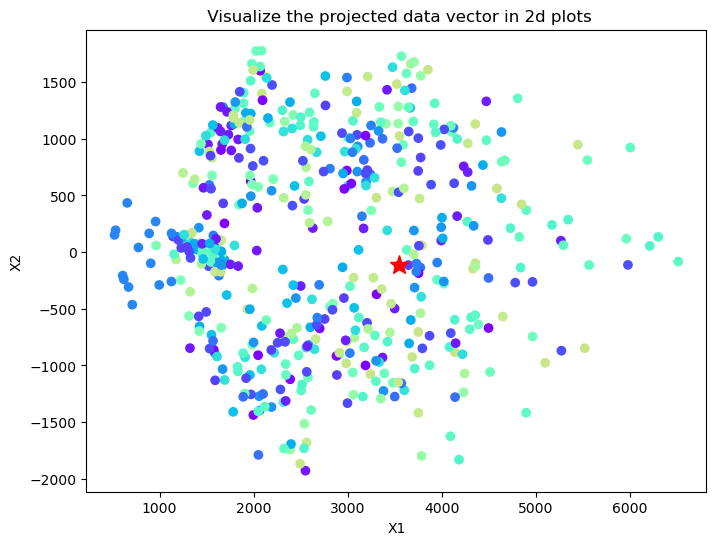

In [12]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
scatter = ax.scatter(X_restructure_200[:,0], X_restructure_200[:,1], c=y_train ,cmap = 'rainbow')
indices = [i for i, x in enumerate(y_train) if x == 100] # the position of self photo
plt.plot(X_restructure_200[indices,0], X_restructure_200[indices,1],  'r*', markersize=14)
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_title(' Visualize the projected data vector in 2d plots')
plt.show()

## 3D PCA plot

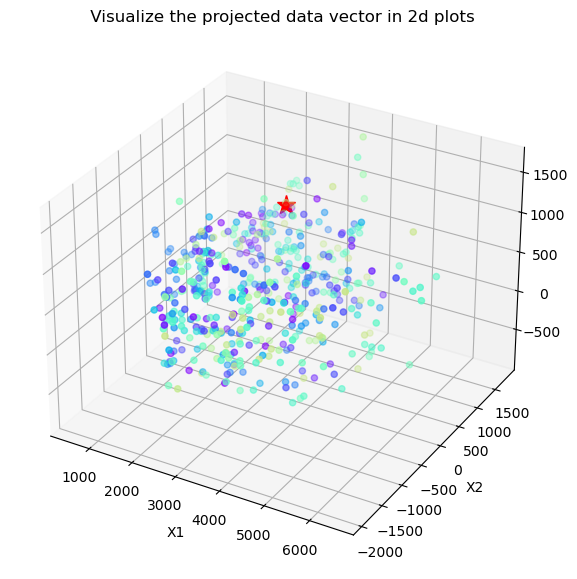

In [13]:

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_restructure_200[:,0], X_restructure_200[:,1],X_restructure_200[:,2], c=y_train ,cmap = 'rainbow')
indices = [i for i, x in enumerate(y_train) if x == 100] # the position of self photo
plt.plot(X_restructure_200[indices,0], X_restructure_200[indices,1], X_restructure_200[indices,2], 'r*', markersize=14)
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_title(' Visualize the projected data vector in 2d plots')
plt.show()

## Visualization of face

(-0.5, 31.5, 31.5, -0.5)

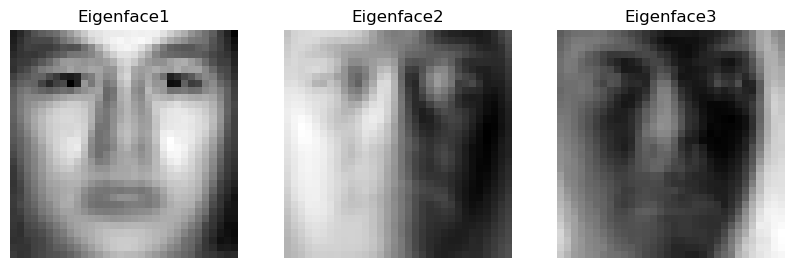

In [14]:
def ComputeEigenface(eigenface):
    normalized = (
        (eigenface - np.min(eigenface)) / (np.max(eigenface) - np.min(eigenface)) * 255
    )
    return Image.fromarray(normalized.astype("uint8").reshape(32, 32), "L")

#===========================================
face_1 = ComputeEigenface(U[:,0])
face_2 = ComputeEigenface(U[:,1])
face_3 = ComputeEigenface(U[:,2])
# plot
plt.figure(figsize=(10,8))
plt.subplot(1, 3, 1)
plt.imshow(face_1, cmap = 'gray')
plt.title('Eigenface'+ str(1))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(face_2, cmap = 'gray')
plt.title('Eigenface'+ str(2))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(face_3, cmap = 'gray') 
plt.title('Eigenface'+ str(3))
plt.axis('off')

## reduce dim to 40, 80 ,200 respectively

In [15]:
## process test data

## PIE test data 
PIEtest = np.array(test_set_list[:-3])
PIEtest = PIEtest.reshape(1269,1024)
# PIE data projection
PIEtest_restructure =  U_200.T @ PIEtest.T
PIEtest_restructure = PIEtest_restructure.T   # (1275,200)

## self test data
SELFtest = np.array(test_set_list[-3:])
SELFtest = SELFtest.reshape(3,1024)
# SELF data projection
SELFtest_restructure =  U_200.T @ SELFtest.T
SELFtest_restructure = SELFtest_restructure.T  #(3,200)

In [16]:
SELFtest_restructure.shape

(3, 200)

In [17]:
def NN_classification(dim, X_test, y_test):
    norm_test_train = LA.norm(X_test[:, :dim][:, np.newaxis] - X_restructure_200[:, :dim], axis=2)
    norm_test_train = np.argsort(norm_test_train)  
    #print(dist_arr_test.shape)

    min_idx = norm_test_train[:, :1]
    
    knn_labels = []
    for single_idx in min_idx:
        knn_labels.append(y_train[int(single_idx)])

    knn_labels = np.array(knn_labels)
    acc = np.sum(knn_labels == y_test) / len(y_test)

    return acc

def Accuracy(X_test, y_test):
    for i in [40, 80 , 200 ]:
        print("Accuracy with dim",i,"=",NN_classification(i, X_test, y_test),)

In [18]:
print("For PIE:")
Accuracy(PIEtest_restructure, test_label_list[:-3])
print("For own photos:")
Accuracy(SELFtest_restructure, test_label_list[-3:])

For PIE:
Accuracy with dim 40 = 0.5066981875492513
Accuracy with dim 80 = 0.5421591804570528
Accuracy with dim 200 = 0.5650118203309693
For own photos:
Accuracy with dim 40 = 0.0
Accuracy with dim 80 = 0.0
Accuracy with dim 200 = 0.0
